# Interpolate 5D beam density

The goal of this notebook is to obtain the 5D phase space density (x-x'-y-y'-w) on a regular (evenly spaced, upright) grid. We also visualize the 5D array in (unsheared) slit-screen coordinates.

$x_3$ = x position at VS34 \
$y_3$ = y position at VS34 \
$x_2$ = position of VT06 slit \
$y_1$ = position of HZ04 slit \
$x_1$ = position of VT04 slit

$$
\begin{aligned}
x &= x_1 \\
y &= y_1 \\
x' &= \frac{x_2 - 0.35 x_1}{s_2 - s_1} \\
y' &= \frac{y_3 - y_1}{s_3 - s_1} \\
w  &= f(x_3, x_2, x_1) \\ 
\end{aligned}
$$

In [1]:
import sys
import os
from os.path import join
import time
from datetime import datetime
import importlib
import numpy as np
import pandas as pd
import h5py
import imageio
from scipy import ndimage
from scipy import interpolate
import skimage
from tqdm import tqdm
from tqdm import trange
from matplotlib import pyplot as plt
from matplotlib import colors
import plotly.graph_objs as go
from ipywidgets import interact
import proplot as pplt

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils
from tools.utils import project

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

## Load 5D array 

In [3]:
folder = '_output'
filenames = os.listdir(folder)
for filename in filenames:
    if filename.startswith('rawgrid'):
        print(filename)
    if filename.startswith('slit_coordinates'):
        print(filename)

slit_coordinates_220429190854-scan-xxpy-image-ypdE.npy
rawgrid_220429190854-scan-xxpy-image-ypdE.mmp


In [4]:
filename = 'rawgrid_220429190854-scan-xxpy-image-ypdE.mmp'
coordfilename = 'slit_coordinates_220429190854-scan-xxpy-image-ypdE.npy'

In [5]:
info = utils.load_pickle('_output/info.pkl')
info

{'acts': ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync'],
 'slit_dict': {'y1': {'pvname': 'ITSF_Diag:Slit_HZ34a',
   'center': 6.5,
   'distance': 14.5,
   'steps': 32,
   'min': -50.0,
   'max': 50.0},
  'x2': {'pvname': 'ITSF_Diag:Slit_VT34b',
   'center': 15.0,
   'distance': 24.0,
   'steps': 32,
   'min': -50.0,
   'max': 50.0},
  'x1': {'pvname': 'ITSF_Diag:Slit_VT34a',
   'center': 21.0,
   'distance': 17.5,
   'steps': 32,
   'min': -50.0,
   'max': 50.0}},
 'M': array([[1. , 0. , 0. ],
        [0. , 1. , 1.9],
        [0. , 0. , 1. ]]),
 'ndim': 3,
 'boundary': None,
 'cam': 'cam34',
 'cam_zoom': 0.5,
 'cam_pix2mm': 0.1,
 'cam_shape': (512, 612),
 'image_offset': 28,
 'image_background_frame': 31474,
 'image_background_rows': (430, 440),
 'image_background_cols': (430, 440),
 'image_background_mean': 27.409846153846154,
 'image_thresh': 0,
 'processed_image_downscale_factor': 3,
 'image_crop_edges': {'x1': 45, 'x2': -30, 'y1': 45, 'y2': -28},
 'image_shape': (98, 129),

In [6]:
shape = info['rawgrid_shape']  # (x1, x2, y1, y3, x3)
dtype = info['im_dtype']
cam = info['cam']

In [7]:
a5d = np.memmap(join(folder, filename), shape=shape, dtype=dtype, mode='r')
print(np.info(a5d))

class:  memmap
shape:  (33, 33, 32, 98, 129)
strides:  (106799616, 3236352, 101136, 1032, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7f79e0847000
byteorder:  little
byteswap:  False
type: float64
None


Use the Right Hand Rule to determine the beam coordinates. [Insert image here].
* Cam06 
    * x_slit (x1, x2) = x_beam
    * y_slit (y1) = -y_beam
    * y_screen (y3) = -y_beam
    * x_screen (x3) = -x_beam    
* Cam34
    * x_slit (x1, x2) = -x_beam (Are you sure??? Seems to give the wrong answer.)
    * y_slit (y1) = -y_beam
    * y_screen (y3) = -y_beam
    * x_screen (x3) = +x_beam

In [8]:
if cam.lower() == 'cam06':
    a5d = a5d[:, :, ::-1, ::-1, ::-1]
elif cam.lower() == 'cam34':
    # a5d = a5d[::-1, ::-1, ::-1, ::-1, :]
    a5d = a5d[:, :, ::-1, ::-1, :]

## Load slit coordinates

In [9]:
coords_3d = np.load(join(folder, coordfilename))  # [X1, X2, Y1]
coords_3d.shape

(3, 33, 33, 32)

In [10]:
dims = ["x1", "x2", "y1", "y3", "x3"]
dim_to_int = {dim: i for i, dim in enumerate(dims)}

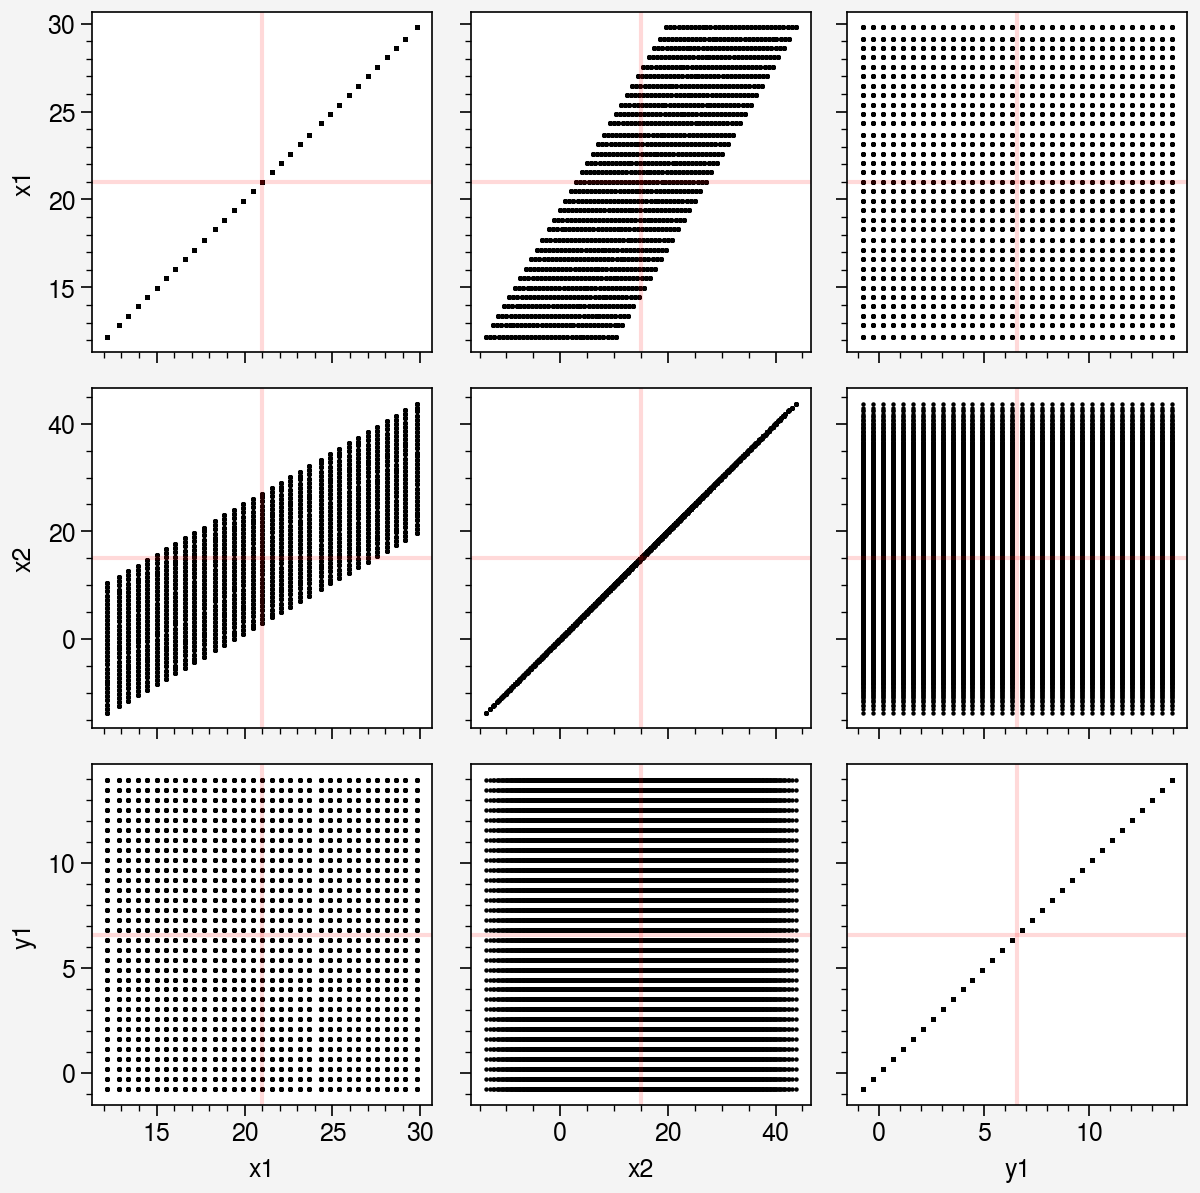

In [11]:
fig, axes = pplt.subplots(nrows=3, ncols=3, figwidth=6, spanx=False, spany=False)
for i in range(3):
    for j in range(3):
        U = coords_3d[j]
        V = coords_3d[i]
        ax = axes[i, j]
        ax.scatter(U.ravel(), V.ravel(), s=1, color='black')
        ax.axvline(np.mean(U), color='red', alpha=0.15)
        ax.axhline(np.mean(V), color='red', alpha=0.15)
    axes[i, 0].format(ylabel=dims[i])
    axes[-1, i].format(xlabel=dims[i])
plt.show()

Copy the grids to cover the five-dimensional space.

In [12]:
X1, X2, Y1 = coords_3d
X1 = utils.copy_into_new_dim(X1, shape[3:], axis=-1)
X2 = utils.copy_into_new_dim(X2, shape[3:], axis=-1)
Y1 = utils.copy_into_new_dim(Y1, shape[3:], axis=-1)

In [13]:
print('X1.shape =', X1.shape)
print('X2.shape =', X2.shape)
print('Y1.shape =', Y1.shape)

X1.shape = (33, 33, 32, 98, 129)
X2.shape = (33, 33, 32, 98, 129)
Y1.shape = (33, 33, 32, 98, 129)


In [14]:
Y3, X3 = np.meshgrid(np.arange(shape[3]), np.arange(shape[4]), indexing='ij')
Y3 = utils.copy_into_new_dim(Y3, shape[:3], axis=0)
X3 = utils.copy_into_new_dim(X3, shape[:3], axis=0)

In [15]:
print('Y3.shape =', Y3.shape)
print('X3.shape =', X3.shape)

Y3.shape = (33, 33, 32, 98, 129)
X3.shape = (33, 33, 32, 98, 129)


Make lists of centered coordinates. `coords_` has coordinates in raw slit values.

In [16]:
X1 = X1 - np.mean(X1)
X2 = X2 - np.mean(X2)
Y1 = Y1 - np.mean(Y1)
Y3 = Y3 - np.mean(Y3)
X3 = X3 - np.mean(X3)
coords_ = [X1, X2, Y1, Y3, X3]

In [17]:
for i, dim in enumerate(dims):
    print('dim =', dim)
    U = coords_[i]
    axes = [k for k in range(U.ndim) if k != i]
    idx = utils.make_slice(U.ndim, axes, ind=[0, 0, 0, 0])
    print(U[idx])
    print()

dim = x1
[-8.79636364e+00 -8.15272727e+00 -7.61636364e+00 -7.08000000e+00
 -6.54363636e+00 -6.00727273e+00 -5.47090909e+00 -4.93454545e+00
 -4.39818182e+00 -3.86181818e+00 -3.32545455e+00 -2.68181818e+00
 -2.14545455e+00 -1.60909091e+00 -1.07272727e+00 -5.36363636e-01
 -3.46744855e-12  5.36363636e-01  1.07272727e+00  1.60909091e+00
  2.14545455e+00  2.68181818e+00  3.32545455e+00  3.86181818e+00
  4.39818182e+00  4.93454545e+00  5.47090909e+00  6.00727273e+00
  6.54363636e+00  7.08000000e+00  7.61636364e+00  8.15272727e+00
  8.79636364e+00]

dim = x2
[-28.7409503  -28.00754424 -27.27413818 -26.39405091 -25.66064485
 -24.92723879 -24.19383273 -23.46042667 -22.72702061 -21.99361455
 -21.26020848 -20.52680242 -19.64671515 -18.91330909 -18.17990303
 -17.44649697 -16.71309091 -15.97968485 -15.24627879 -14.51287273
 -13.77946667 -12.89937939 -12.16597333 -11.43256727 -10.69916121
  -9.96575515  -9.23234909  -8.49894303  -7.76553697  -7.03213091
  -6.15204364  -5.41863758  -4.68523152]

dim =

## View 5D array in slit-screen coordinates

Correlation between planes are removed... units are dimensionless. Need to be careful interpreting these plots.

### Projections 

In [18]:
a5d_min = np.min(a5d)
if a5d_min < 0:
    print(f'min(a5d) = {a5d_min}. Clipping to 0.')
    a5d = np.clip(a5d, 0, None)

min(a5d) = -2.220446049250313e-16. Clipping to 0.


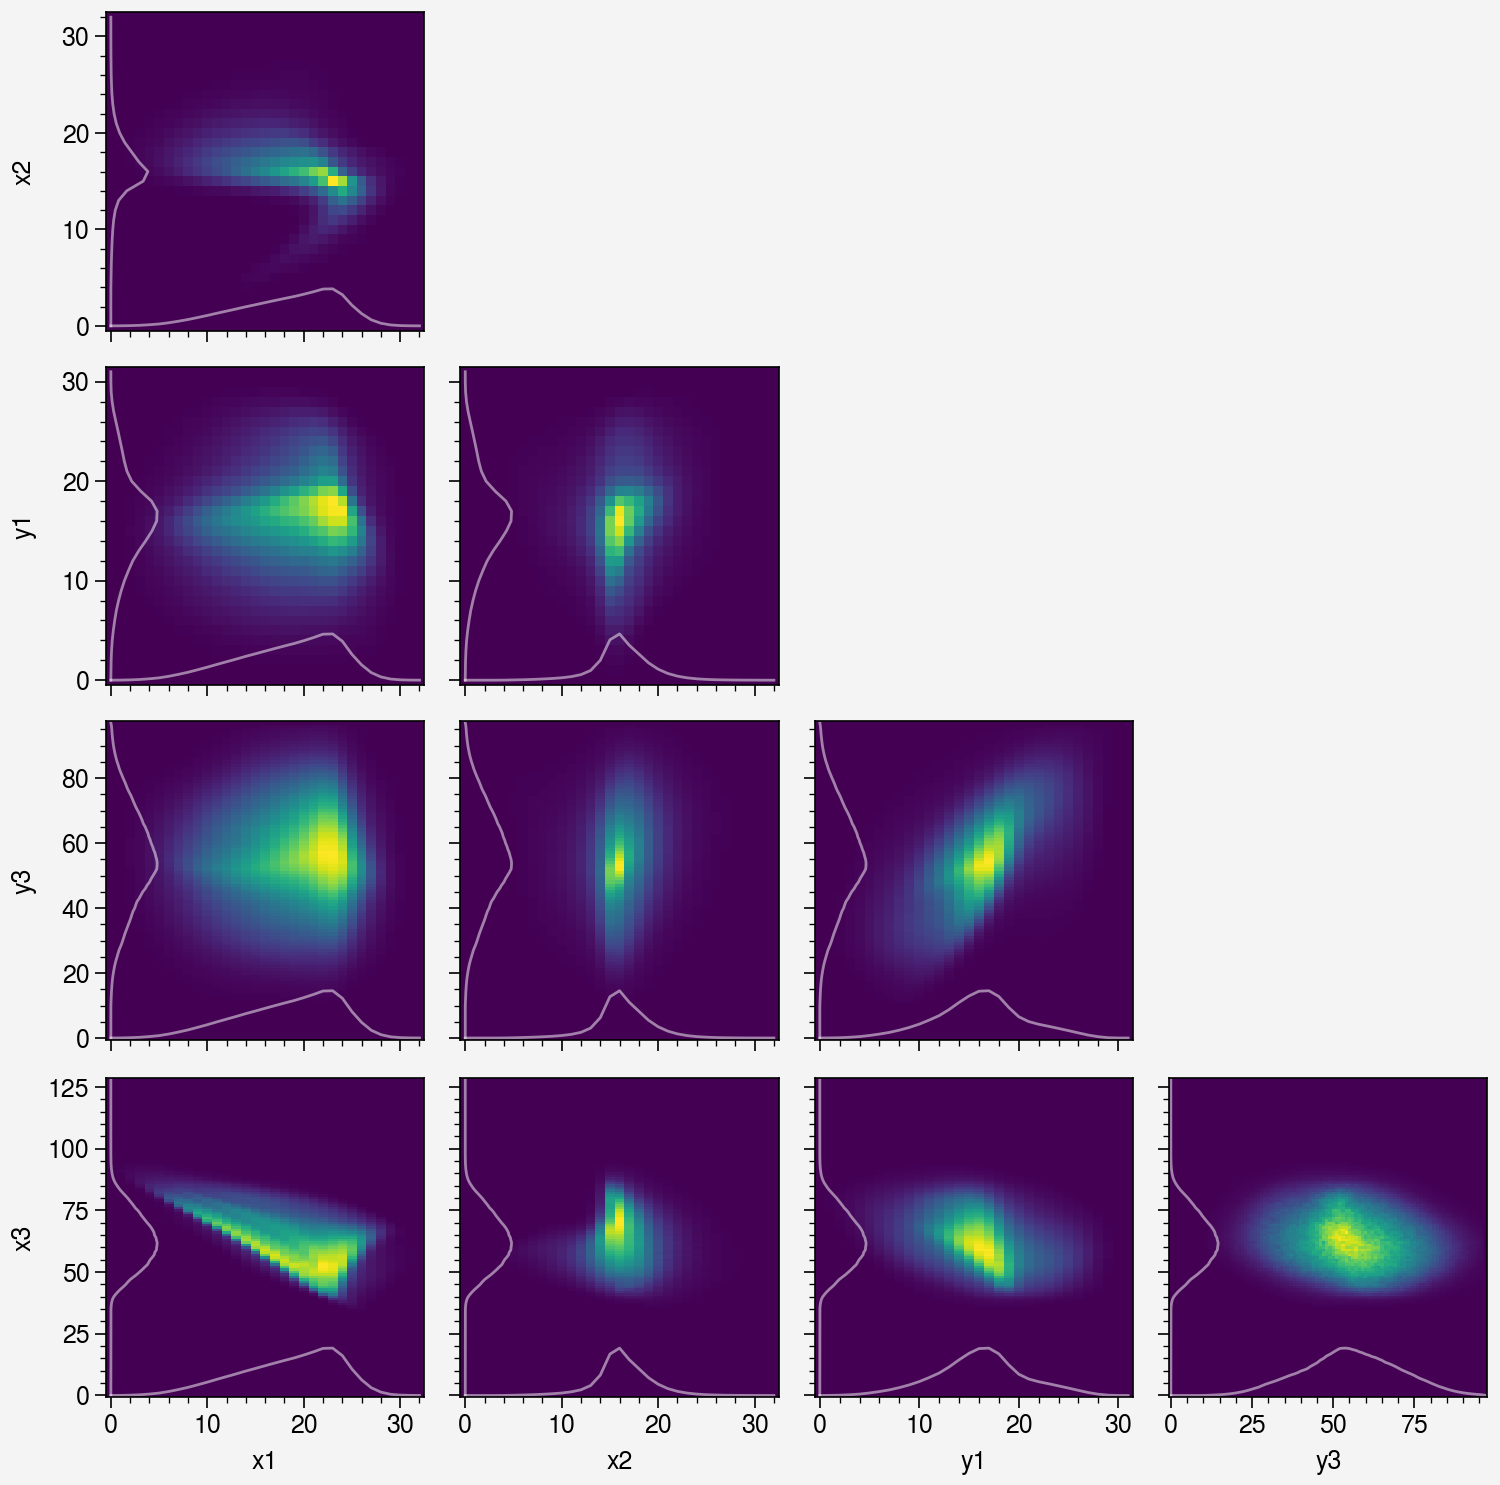

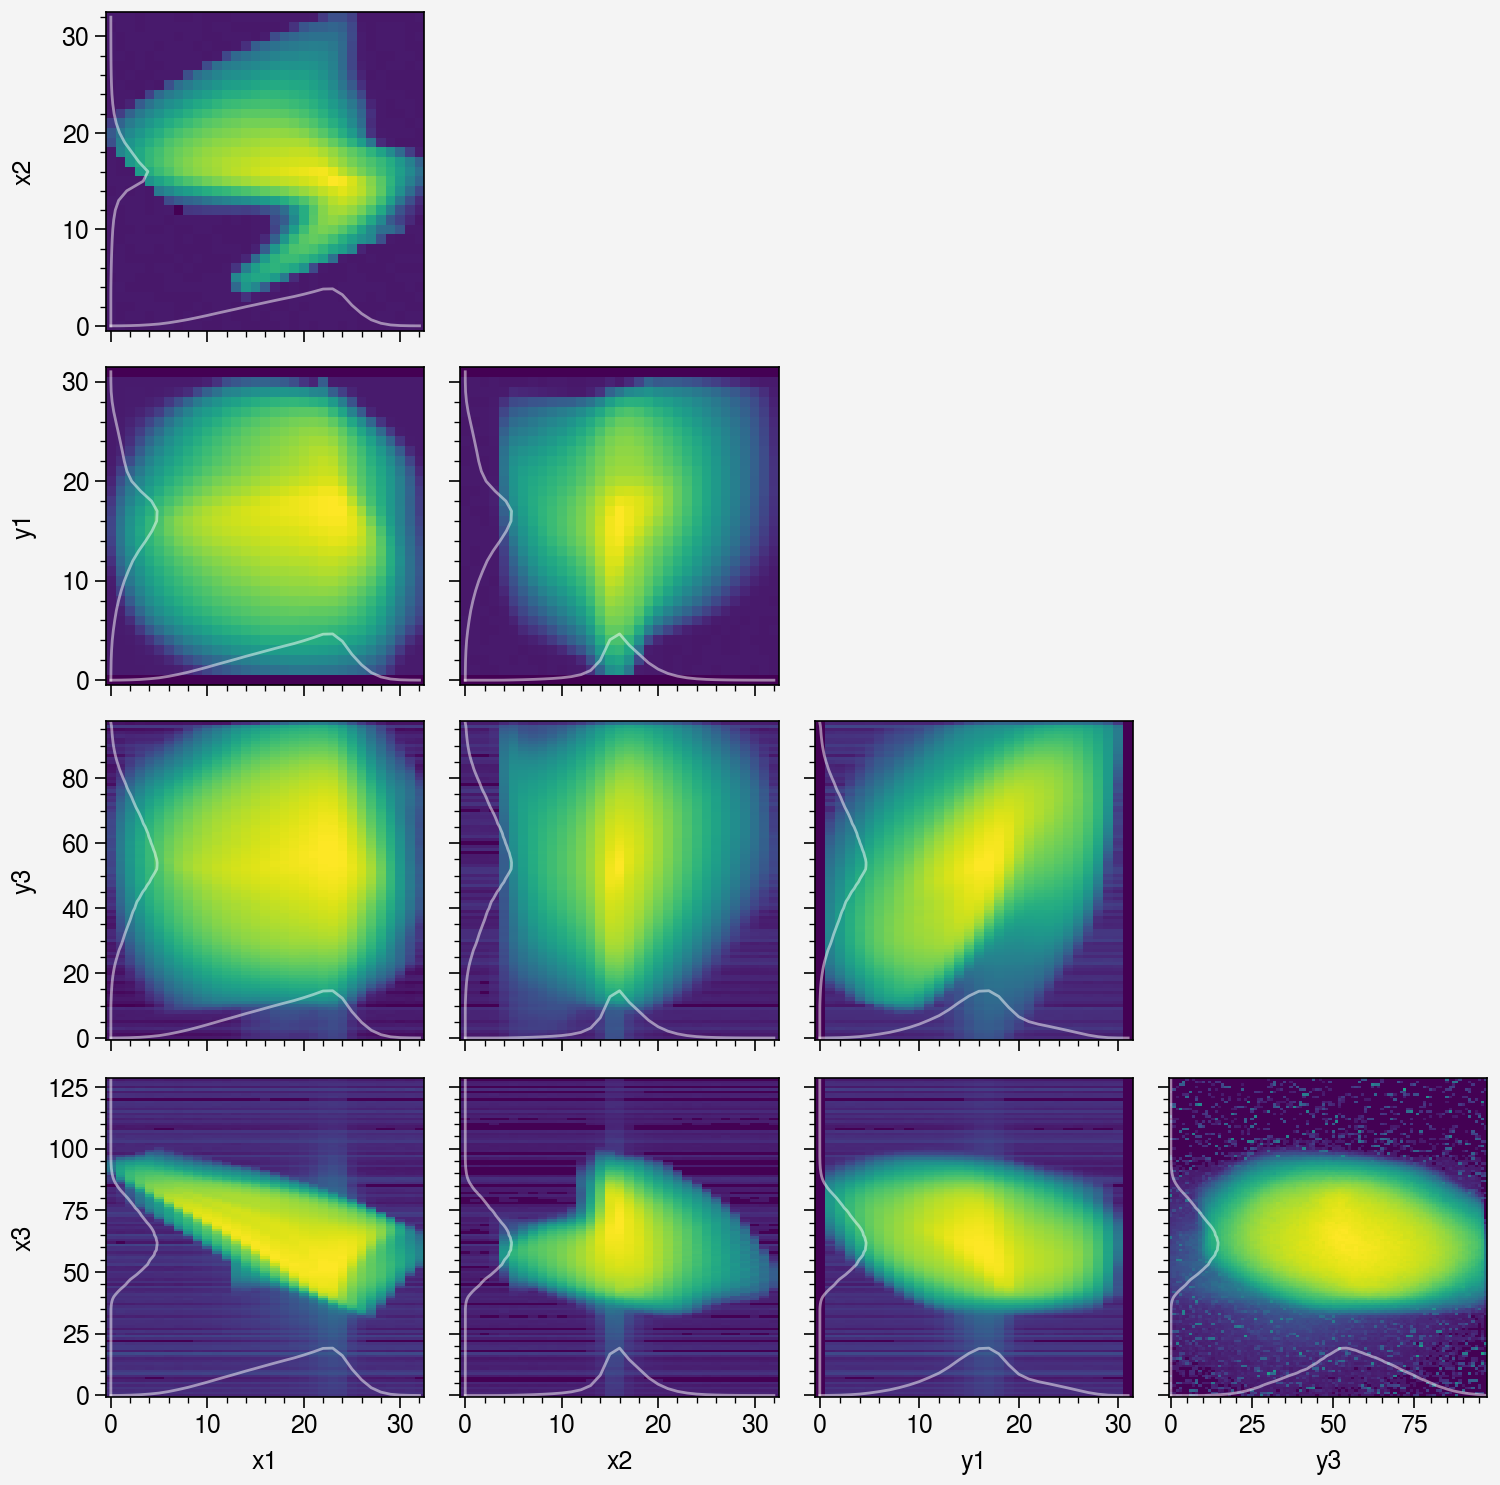

In [19]:
frac_thresh = 1e-5
for norm in [None, 'log']:
    axes = mplt.corner(
        a5d,
        labels=dims,
        norm=norm,
        diag_kind='None',
        prof=True,
        prof_kws=dict(lw=1.0, alpha=0.5, scale=0.12),
        fig_kws=dict(),
        frac_thresh=frac_thresh,
    )
    plt.savefig(f"_output/slitscreen_corner_log{norm == 'log'}.png")
    plt.show()

### Slices

Compute the indices of the maximum pixel in the 5D array.

In [20]:
ind = np.unravel_index(np.argmax(a5d), a5d.shape)
ind = tuple([i for i in ind])
print(ind)

(22, 17, 18, 59, 45)


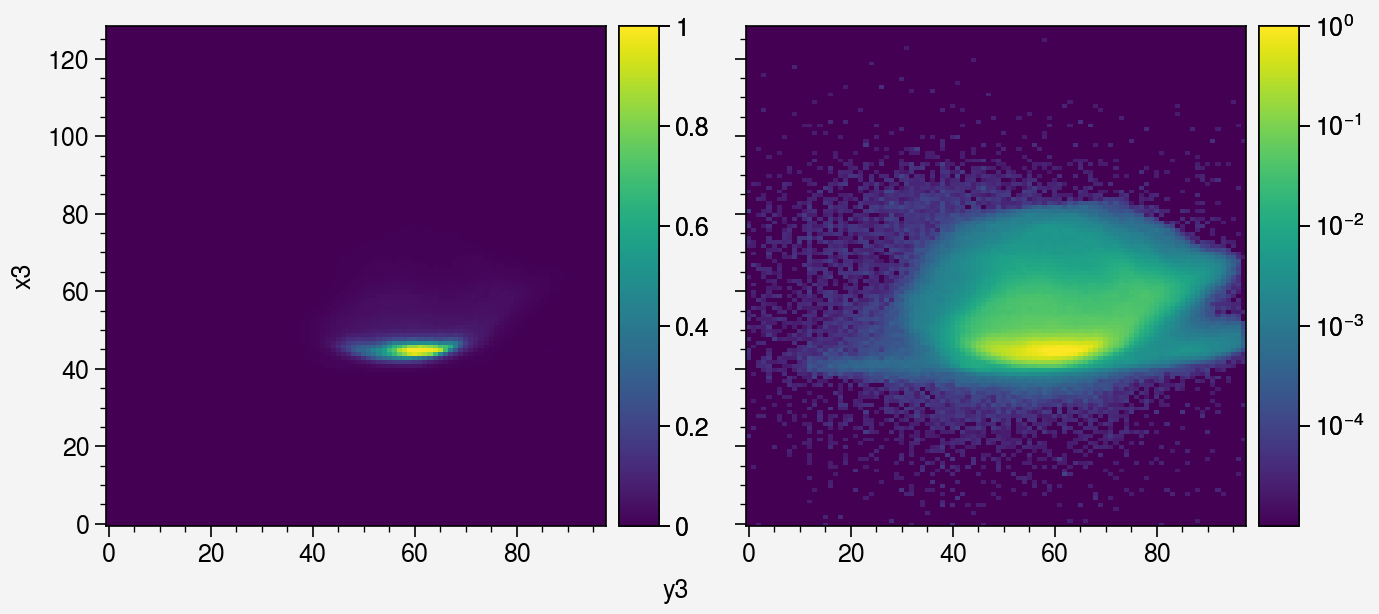

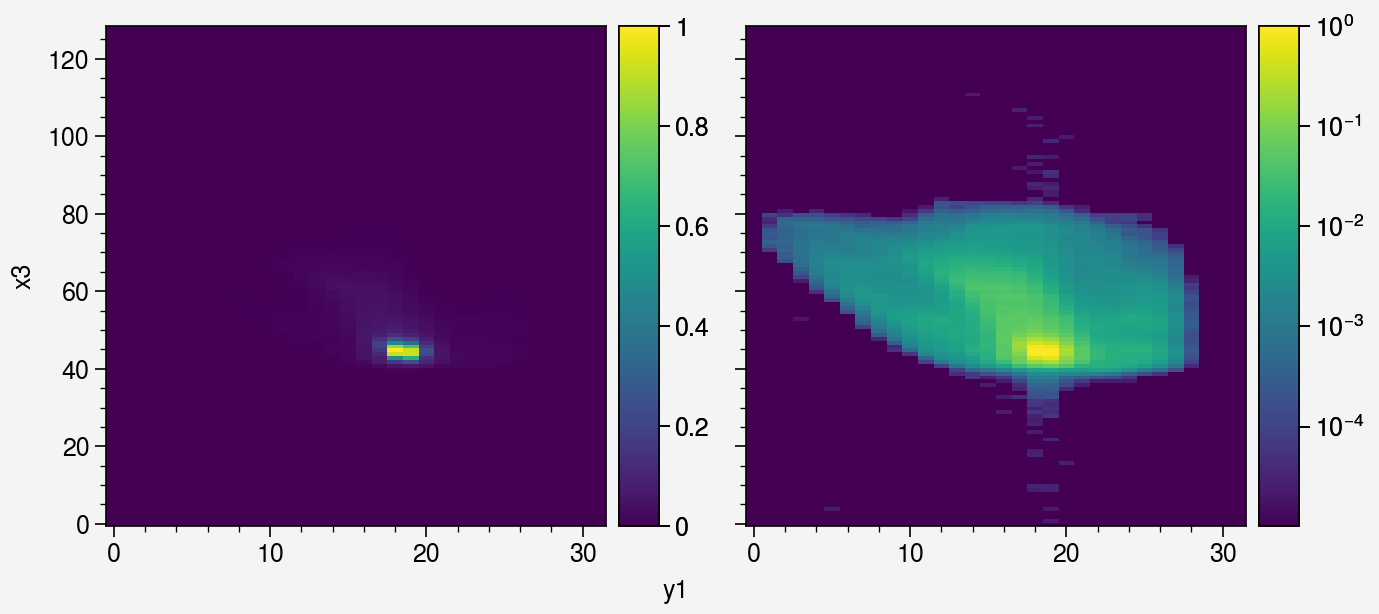

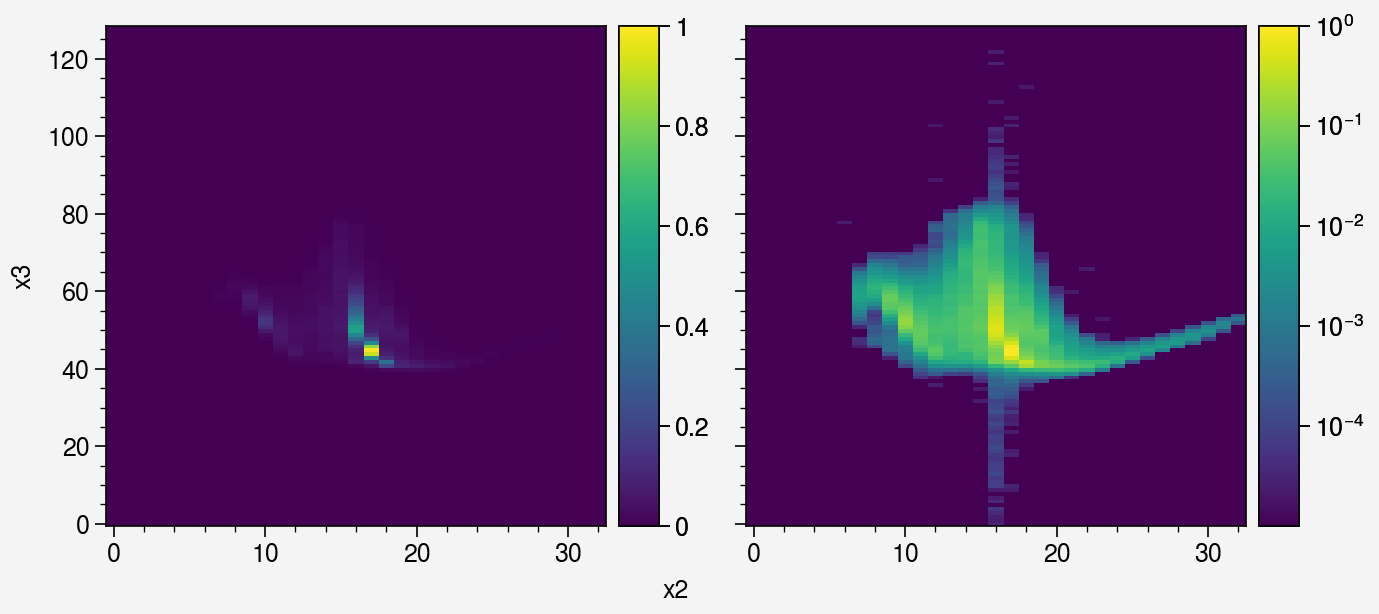

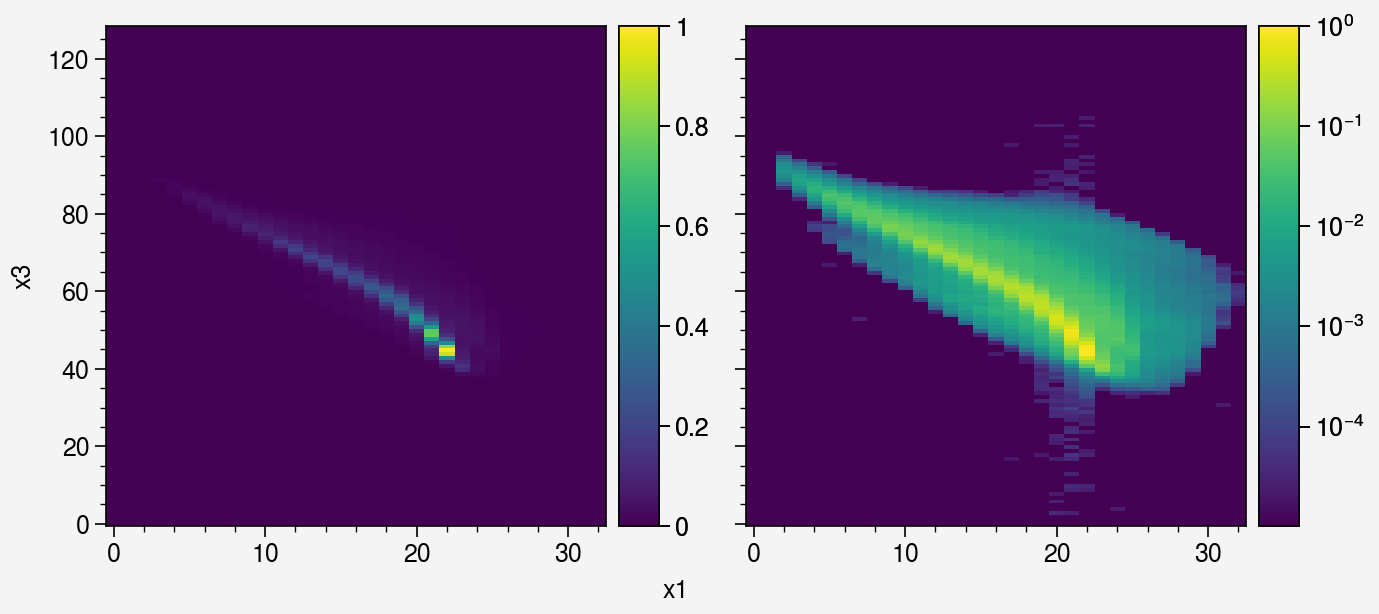

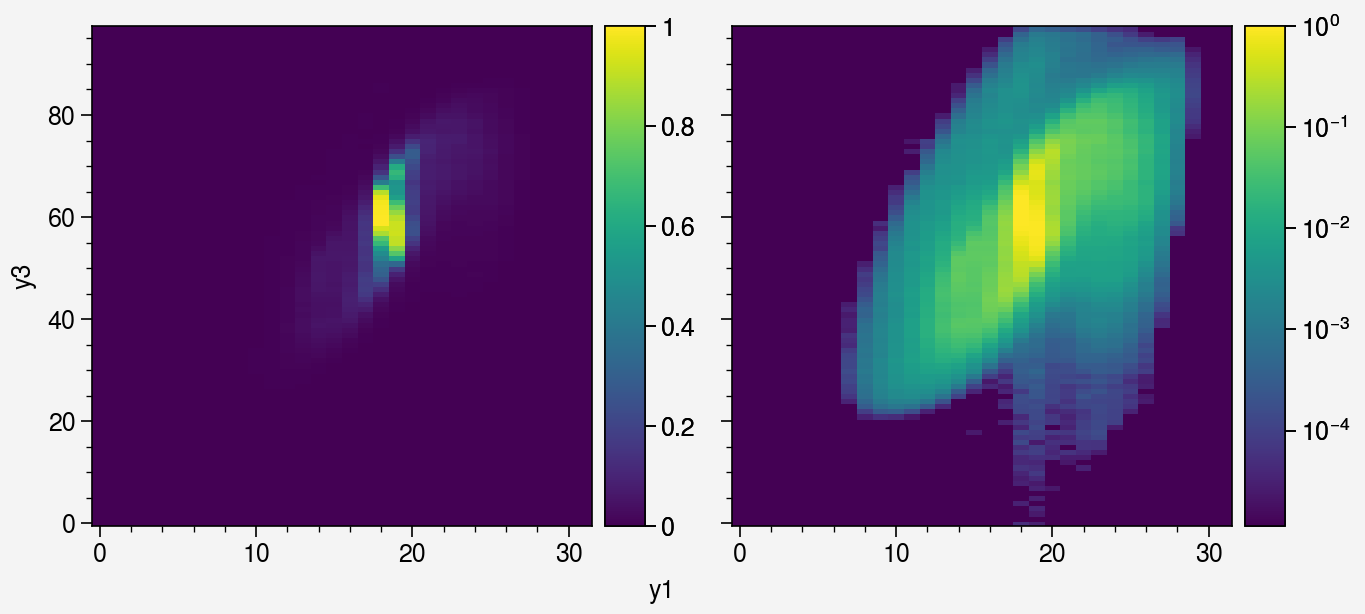

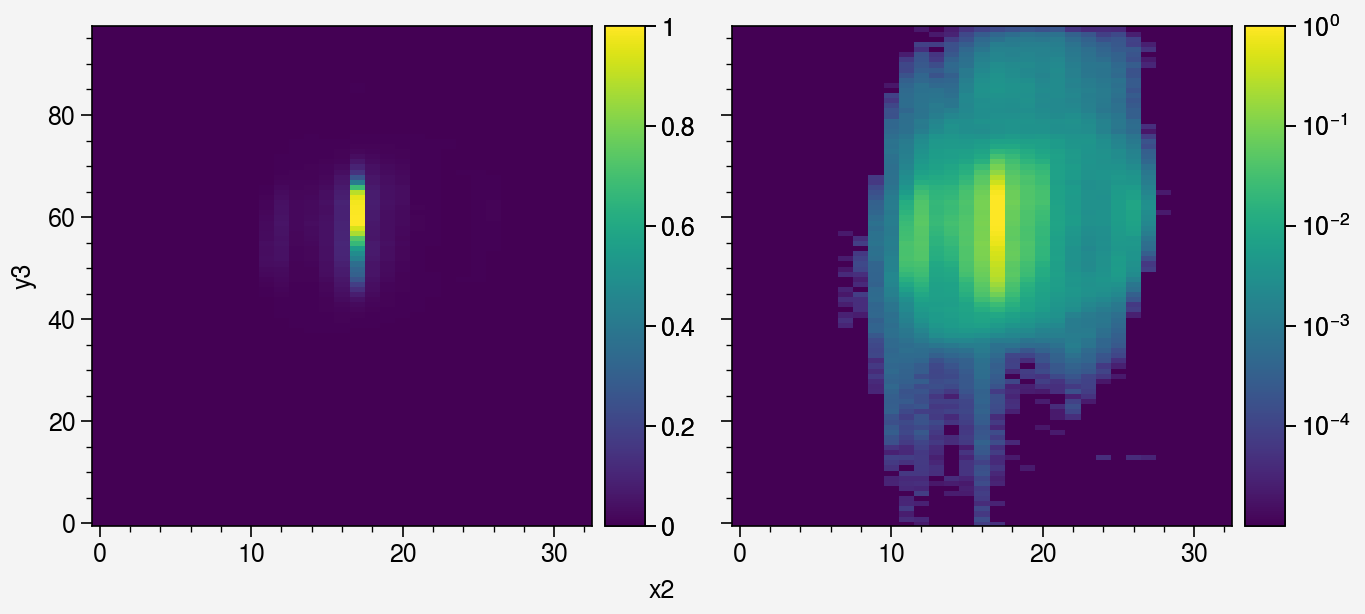

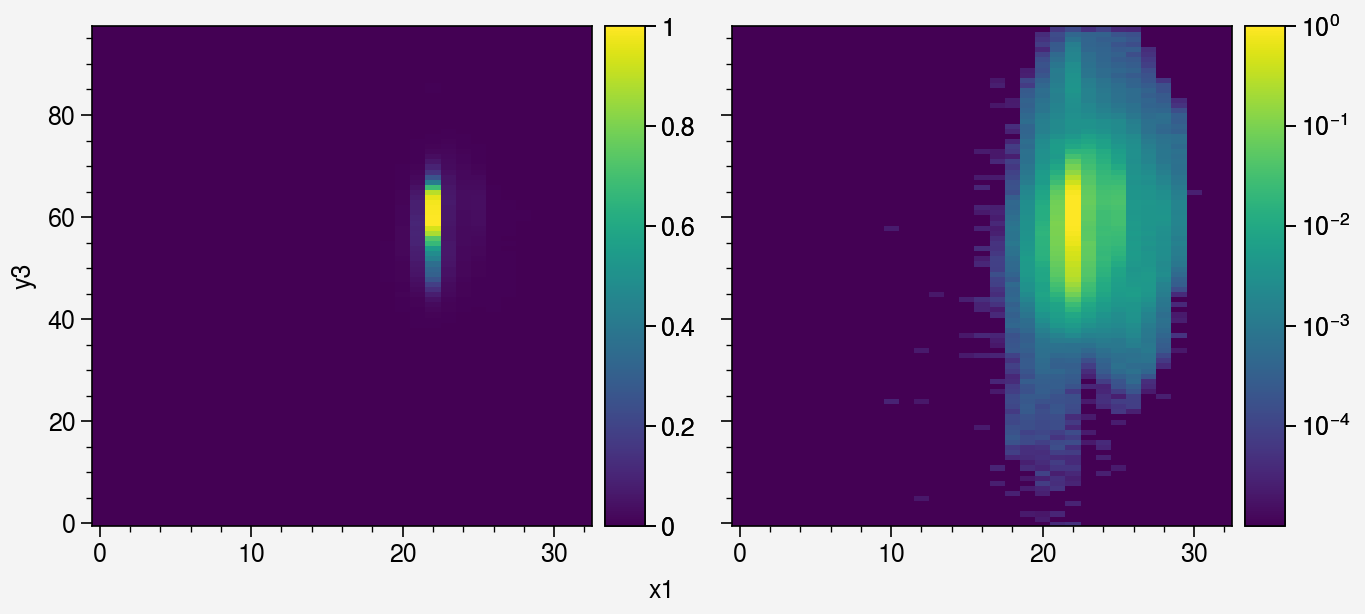

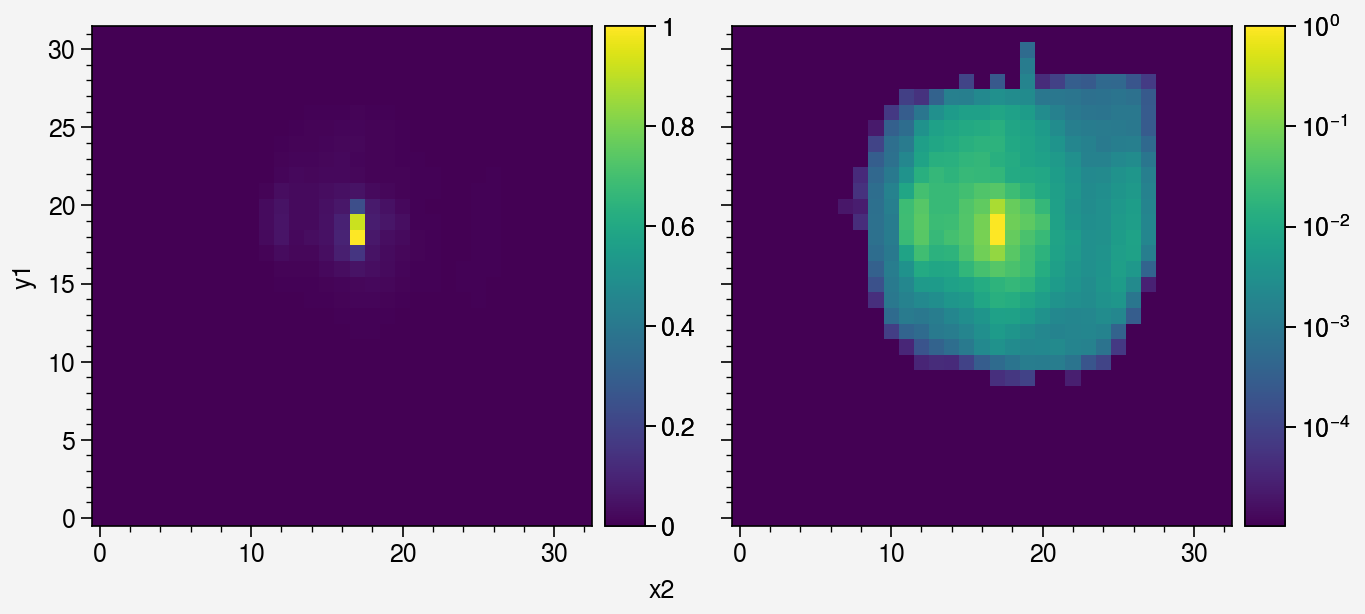

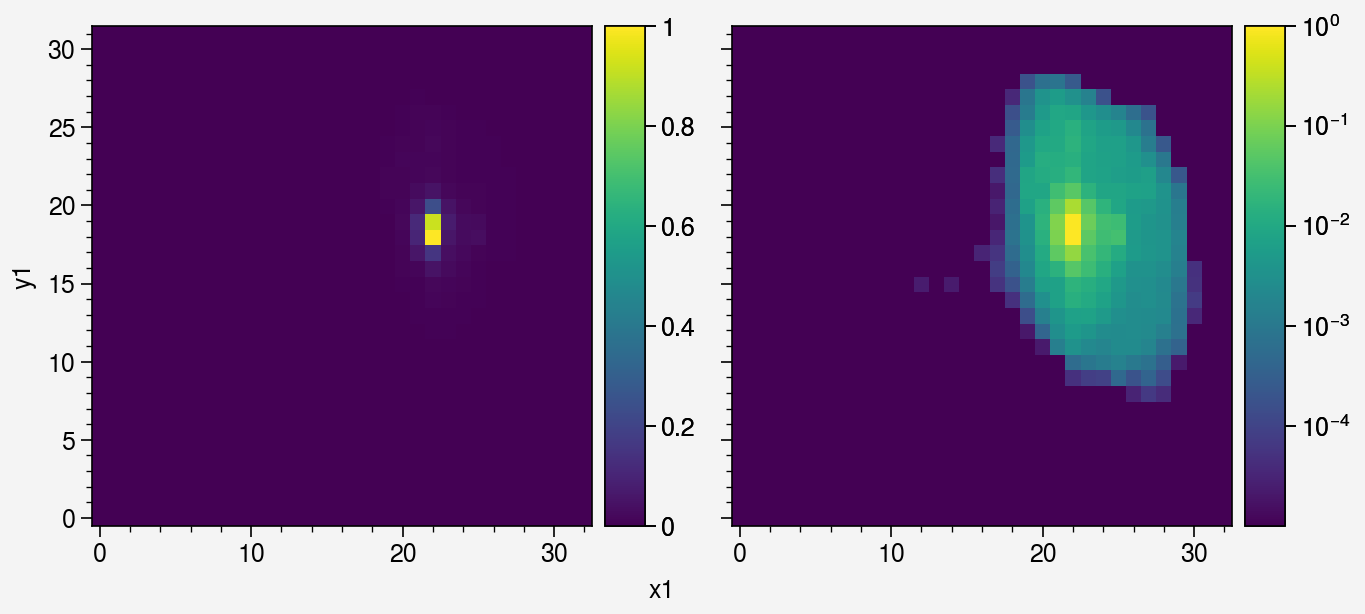

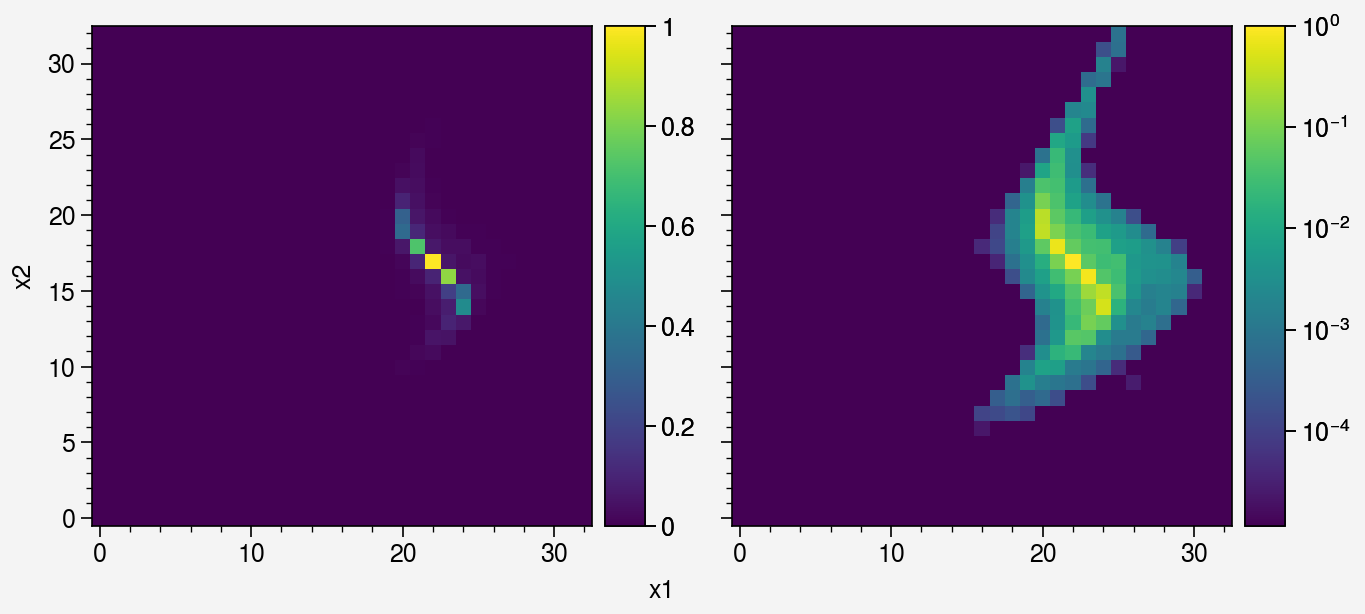

In [21]:
axes_slice = [(k, j, i) for i in range(a5d.ndim) for j in range(i) for k in range(j)]
axes_view = [tuple([i for i in range(a5d.ndim) if i not in axis])
             for axis in axes_slice]
for axis, axis_view in zip(axes_slice, axes_view):
    idx = utils.make_slice(5, axis, [ind[i] for i in axis])
    a5d_slice = a5d[idx]
    a5d_slice = a5d_slice / np.max(a5d_slice)

    dim1, dim2 = [dims[i] for i in axis_view]
    
    fig, plot_axes = pplt.subplots(ncols=2)
    for ax, norm in zip(plot_axes, [None, 'log']):
        mplt.plot_image(a5d_slice, ax=ax, frac_thresh=frac_thresh, norm=norm, colorbar=True)
    plot_axes.format(xlabel=dim1, ylabel=dim2)
    string = '_output/slitscreen_slice_'
    for i in axis:
        string += f'_{dims[i]}-{ind[i]}'
    plt.savefig(string + '.png')
    plt.show()

### Interactive 

In [22]:
mplt.interactive_proj2d(a5d / np.max(a5d), dims=['x1', 'x2', 'y1', 'y3', 'x3'], 
                        slider_type='int', default_ind=(4, 3))

interactive(children=(Dropdown(description='cmap', options=('viridis', 'dusk_r', 'mono_r', 'plasma'), value='v…

In [23]:
mplt.interactive_proj2d(a5d / np.max(a5d), dims=['x1', 'x2', 'y1', 'y3', 'x3'], 
                        slider_type='range', default_ind=(4, 3))

interactive(children=(Dropdown(description='cmap', options=('viridis', 'dusk_r', 'mono_r', 'plasma'), value='v…

## Coordinate transform

Convert x3 and y3 from pixels to mm.

In [24]:
cam_settings = ip.camera_settings(cam)
cam_settings.set_zoom(info['cam_zoom'])
pix2mm = float(cam_settings.pix2mm)
print(f"pix2mm = {pix2mm} (zoom = {info['cam_zoom']})")

downscale_factor = info['processed_image_downscale_factor']
pix2mm *= downscale_factor
print(f'pix2mm = {pix2mm} (downscale_factor = {downscale_factor})')

pix2mm = 0.1 (zoom = 0.5)
pix2mm = 0.30000000000000004 (downscale_factor = 3)


In [25]:
X3 = X3 * pix2mm
Y3 = Y3 * pix2mm

Build the transfer matrices between the slits and the screen.

In [26]:
a2mm = 1.009  # assume same for both dipoles
rho = 0.3556
GL05 = 0.0
GL06 = 0.0
l1 = 0.0
l2 = 0.0
l3 = 0.774
L2 = 0.311  # slit2 to dipole face
l = 0.129  # dipole face to VS06 screen (assume same for first/last dipole-screen)
LL = l1 + l2 + l3 + L2  # distance from emittance plane to dipole entrance

ecalc = energy.EnergyCalculate(l1=l1, l2=l2, l3=l3, L2=L2, l=l, amp2meter=a2mm*1e3)
Mslit = ecalc.getM1()  # slit-slit
Mscreen = ecalc.getM()  # slit-screen

Compute x', y', and energy w.

In [27]:
Y = Y1.copy()
YP = ecalc.calculate_yp(Y1 * 1e-3, Y3 * 1e-3, Mscreen)
print('Done with yp.')

X = X1.copy()
XP = ecalc.calculate_xp(X1 * 1e-3, X2 * 1e-3, Mslit)
print('Done with xp.')

W = ecalc.calculate_dE_screen(X3 * 1e-3, 0.0, X * 1e-3, XP * 1e-3, Mscreen)  # [MeV]
print('Done with w.')

# Convert x-x' and y-y' from m-rad to mm-mrad. 
YP *= 1e3
XP *= 1e3

Done with yp.
Done with xp.
Done with w.


In [28]:
del(X1, X2, Y1, X3, Y3)

Make lists of centered phase space coordinate grids.

In [29]:
coords = [X, XP, Y, YP, W]
for coord in tqdm(coords):
    coord = coord - np.mean(coord)

100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


## Interpolation 

It makes sense to increase the grid resolution in some planes since we're going from a tilted grid to an upright grid.

In [60]:
M = info['M']
M

array([[1. , 0. , 0. ],
       [0. , 1. , 1.9],
       [0. , 0. , 1. ]])

In [67]:
new_shape = np.array(shape).astype(float)
new_shape[0] *= 1.1
new_shape[1] *= 2.1
new_shape[2] *= 1.1
new_shape = tuple(new_shape.astype(int))
info['int_shape'] = new_shape
print(new_shape)

(36, 69, 35, 98, 129)


In [68]:
x_gv_new = np.linspace(np.min(X), np.max(X), new_shape[0])
xp_gv_new = np.linspace(np.min(XP), np.max(XP), new_shape[1])
y_gv_new = np.linspace(np.min(Y), np.max(Y), new_shape[2])
yp_gv_new = np.linspace(np.min(YP), np.max(YP), new_shape[3])
w_gv_new = np.linspace(np.min(W), np.max(W), new_shape[4])
new_coords = [x_gv_new, xp_gv_new, y_gv_new, yp_gv_new, w_gv_new]
utils.save_stacked_array('_output/coords.npz', new_coords)

### Test: put 2D projected phase spaces projection on upright grid

H_new.min() = 0.0


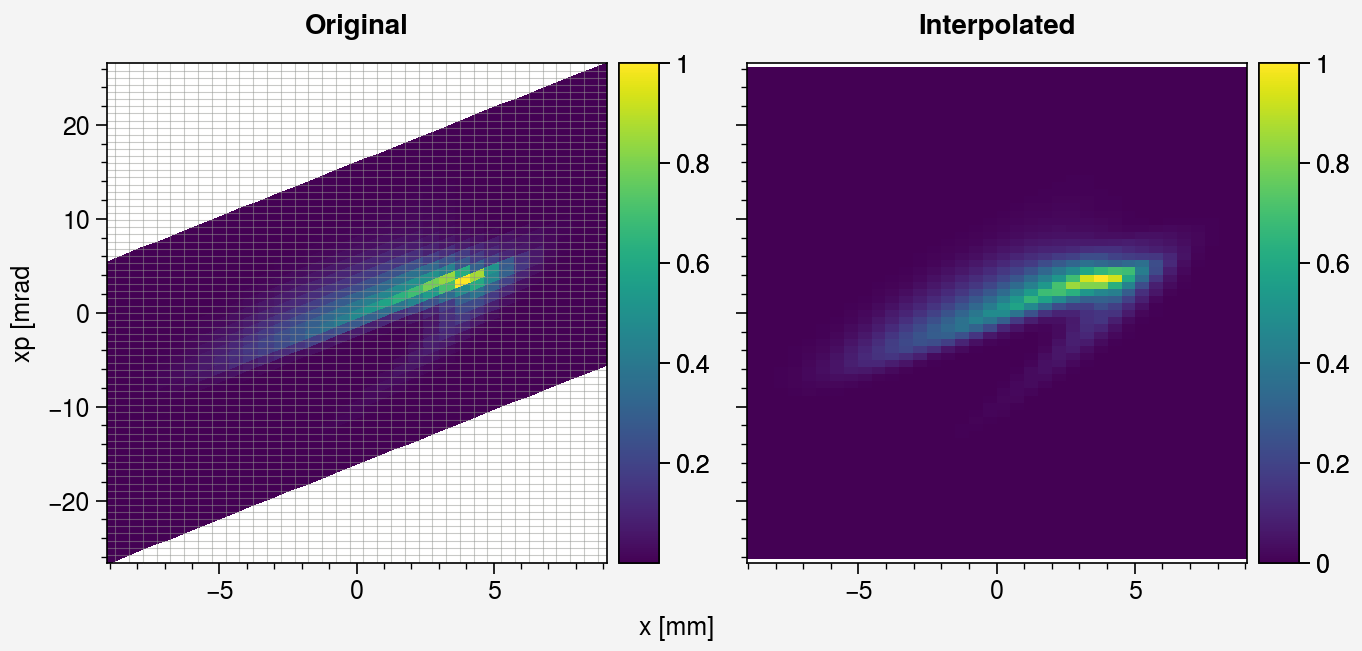

H_new.min() = 0.0


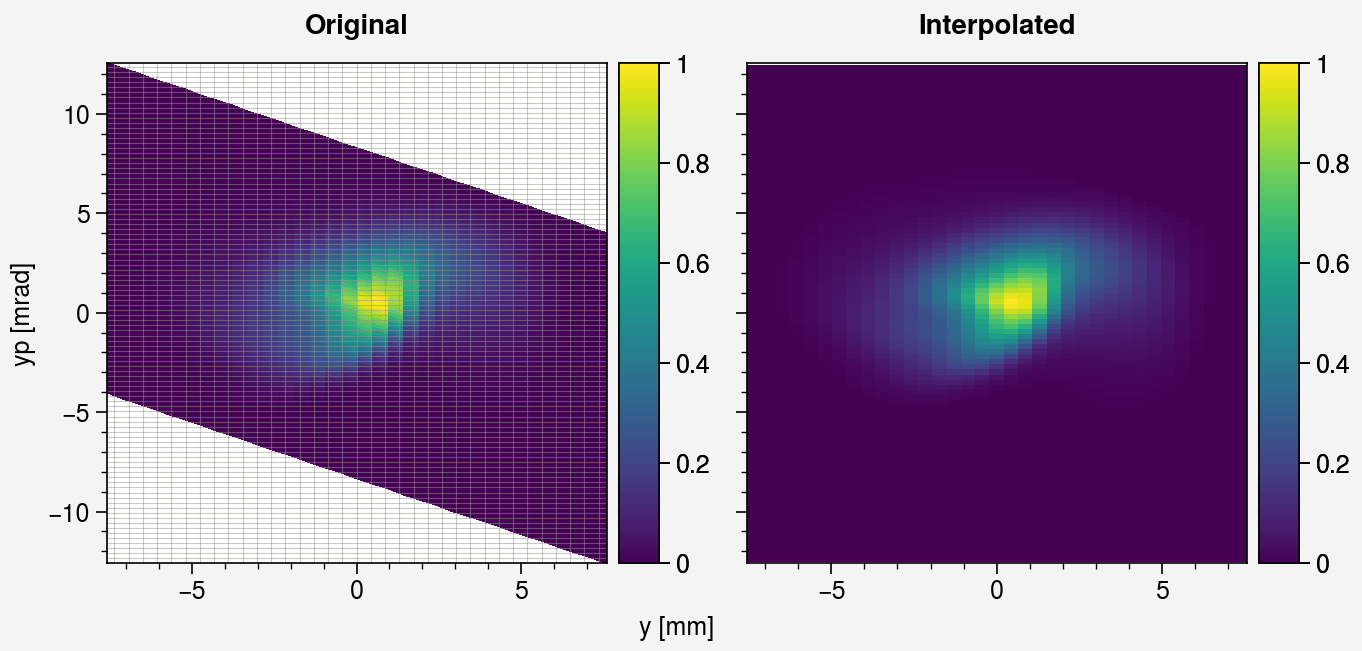

In [69]:
grid = True
contour = False
norm = None

gvs = [x_gv_new, xp_gv_new, y_gv_new, yp_gv_new]
pdims = ["x [mm]", "xp [mrad", "y [mm]", "yp [mrad]", "w [MeV]"]
for plane, (i, j) in zip(['x', 'y'], [(0, 1), (2, 3)]):
    if plane == 'x':
        U = X[:, :, 0, 0, 0]
        V = XP[:, :, 0, 0, 0]
    elif plane == 'y':
        U = Y[0, 0, :, :, 0]
        V = YP[0, 0, :, :, 0]
    H = utils.project(a5d, axis=(i, j))
    H = H / np.max(H)
    
    points = (U.ravel(), V.ravel())
    values = H.ravel()
    U_new, V_new = np.meshgrid(gvs[i], gvs[j], indexing='ij')
    new_points = (U_new.ravel(), V_new.ravel())
    new_values = interpolate.griddata(points, values, new_points, fill_value=0.0, method='linear')
    H_new = new_values.reshape(len(gvs[i]), len(gvs[j]))
    print(f'H_new.min() = {H_new.min()}')
    H_new = np.clip(H_new, 0.0, None)
    H_new = H_new / np.max(H_new)

    fig, axes = pplt.subplots(ncols=2)
    mplt.plot_image(H, x=U, y=V, ax=axes[0], colorbar=True, norm=norm)
    mplt.plot_image(H_new, x=gvs[i], y=gvs[j], ax=axes[1], colorbar=True, norm=norm)
    if grid:
        kws = dict(c='grey', lw=0.4, alpha=0.5)
        for g in gvs[i]:
            axes[0].axvline(g, **kws)
        for g in gvs[j]:
            axes[0].axhline(g, **kws)
    if contour:
        axes[1].contour(U.T, V.T, H.T, color='white', alpha=0.2, lw=0.75)
    axes.format(xlabel=pdims[i], ylabel=pdims[j], toplabels=['Original', 'Interpolated'])
    plt.show()

### Direct 5D interpolation 

This seems to be infeasible. Skip.

In [70]:
# points = tuple([U.ravel() for U in [X, XP, Y, YP, W]])
# values = a5d.ravel()
# new_points = tuple(
#     [U.ravel() for U in np.meshgrid(x_gv_new, xp_gv_new,
#                                     y_gv_new, yp_gv_new, 
#                                     w_gv_new, indexing='ij')]
# )
# a5d_new = interpolate.griddata(points, values, new_points, 
#                                fill_value=0.0, method='linear')

### Interpolate w for each (x, x', y, y') 

In [71]:
a5d_new = np.zeros((shape[0], shape[1], shape[2], shape[3], new_shape[4]))

In [72]:
new_points = w_gv_new
for i in trange(shape[0]):
    for j in range(shape[1]):
        for k in range(shape[2]):
            for l in range(shape[3]):
                points = coords[4][i, j, k, l, :]
                values = a5d[i, j, k, l, :]
                a5d_new[i, j, k, l, :] = interpolate.griddata(
                    points, 
                    values, 
                    new_points, 
                    fill_value=0.0, 
                    method='linear',
                )

100%|██████████| 33/33 [04:24<00:00,  8.01s/it]


Redefine the grid coordinates — copy the x, x', y, and y' grids along the new w axis.

In [73]:
X = utils.copy_into_new_dim(X[:, :, :, :, 0], (new_shape[4],), axis=-1)
Y = utils.copy_into_new_dim(Y[:, :, :, :, 0], (new_shape[4],), axis=-1)
XP = utils.copy_into_new_dim(XP[:, :, :, :, 0], (new_shape[4],), axis=-1)
YP = utils.copy_into_new_dim(YP[:, :, :, :, 0], (new_shape[4],), axis=-1)
W = utils.copy_into_new_dim(w_gv_new, (shape[0], shape[1], shape[2], shape[3]), axis=0)
coords = [X, XP, Y, YP, W]

In [74]:
for C in coords:
    print(C.shape)

(33, 33, 32, 98, 129)
(33, 33, 32, 98, 129)
(33, 33, 32, 98, 129)
(33, 33, 32, 98, 129)
(33, 33, 32, 98, 129)


### Interpolate x-x' for each (y, y', w)

In [75]:
a5d_new = np.zeros((new_shape[0], new_shape[1], shape[2], shape[3], new_shape[4]))
new_points = tuple([G.ravel() for G in np.meshgrid(x_gv_new, xp_gv_new, indexing='ij')])
for k in trange(a5d.shape[2]):
    for l in range(a5d.shape[3]):   
        for m in range(a5d.shape[4]):
            points = (
                coords[0][:, :, k, l, m].ravel(),
                coords[1][:, :, k, l, m].ravel(),
            )
            values = a5d[:, :, k, l, m].ravel()
            new_values = interpolate.griddata(
                points,
                values,
                new_points,
                fill_value=0.0,
                method='linear',
            )
            a5d_new[:, :, k, l, m] = new_values.reshape((new_shape[0], new_shape[1]))

100%|██████████| 32/32 [1:36:37<00:00, 181.16s/it]


In [76]:
a5d = a5d_new.copy()

Same thing with the coordinates. We now need to copy the x-x' grid along all other dimensions, and y, y', and w along the x and x' dimensions.

In [77]:
_X, _XP = np.meshgrid(x_gv_new, xp_gv_new, indexing='ij')
X = utils.copy_into_new_dim(_X, (shape[2], shape[3], new_shape[4]), axis=-1)
XP = utils.copy_into_new_dim(_XP, (shape[2], shape[3], new_shape[4]), axis=-1)
Y = utils.copy_into_new_dim(Y[0, 0, :, :, :], (new_shape[0], new_shape[1]), axis=0)
YP = utils.copy_into_new_dim(YP[0, 0, :, :, :], (new_shape[0], new_shape[1]), axis=0)
W = utils.copy_into_new_dim(W[0, 0, :, :, :], (new_shape[0], new_shape[1]), axis=0)
coords = [X, XP, Y, YP, W]

In [78]:
for C in coords:
    print(C.shape)

(36, 69, 32, 98, 129)
(36, 69, 32, 98, 129)
(36, 69, 32, 98, 129)
(36, 69, 32, 98, 129)
(36, 69, 32, 98, 129)


### Interpolate y-y' for each (x, x', w)

In [79]:
a5d_new = np.memmap('_output/a5d_new.mmp', shape=new_shape, dtype='float', mode='w+') 
new_points = tuple([G.ravel() for G in np.meshgrid(y_gv_new, yp_gv_new, indexing='ij')])
for i in trange(new_shape[0]):
    for j in range(new_shape[1]):   
        for m in range(new_shape[4]):
            points = (
                coords[2][i, j, :, :, m].ravel(),
                coords[3][i, j, :, :, m].ravel(),
            )
            values = a5d[i, j, :, :, m].ravel()
            new_values = interpolate.griddata(
                points,
                values,
                new_points,
                fill_value=0.0,
                method='linear',
            )
            a5d_new[i, j, :, :, m] = new_values.reshape((new_shape[2], new_shape[3]))

100%|██████████| 36/36 [3:54:53<00:00, 391.49s/it]  


In [80]:
del a5d_new

In [81]:
utils.save_pickle('_output/info.pkl', info)
file = open('_output/info.txt', 'w')
for key, value in info.items():
    file.write(f'{key}: {value}\n')
file.close()